Columns in dataset: ['original_message', 'property_type', 'area_sqft', 'price', 'price_unit', 'rent', 'rent_unit', 'location', 'furnishing', 'transaction_type', 'contact', 'is_real_estate', 'price_lakhs', 'rent_thousands', 'bhk_number', 'price_category', 'rent_category']
                                    original_message  property_type  \
0  2BHK available for rent in Andheri East. 1100 ...            2.0   
1  3BHK luxury flat for sale in Powai. 1850 sqft,...            3.0   
2  1RK studio apartment available in Lokhandwala....            1.0   
3  Shop space available in Bandra West. 800 sqft,...            NaN   
4  2BHK ready to move flat in Malad West. 1200 sq...            2.0   

   area_sqft       price price_unit      rent rent_unit     location  \
0     1100.0         NaN        NaN   65000.0         K      Andheri   
1     1850.0  42000000.0         CR       NaN       NaN        Powai   
2      450.0         NaN        NaN   25000.0         K  Lokhandwala   
3      800.0 

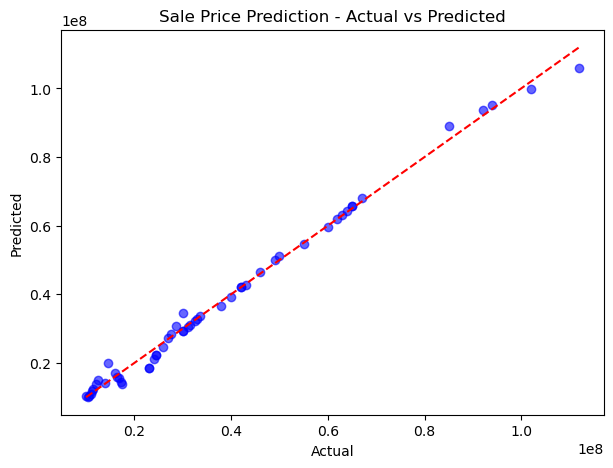

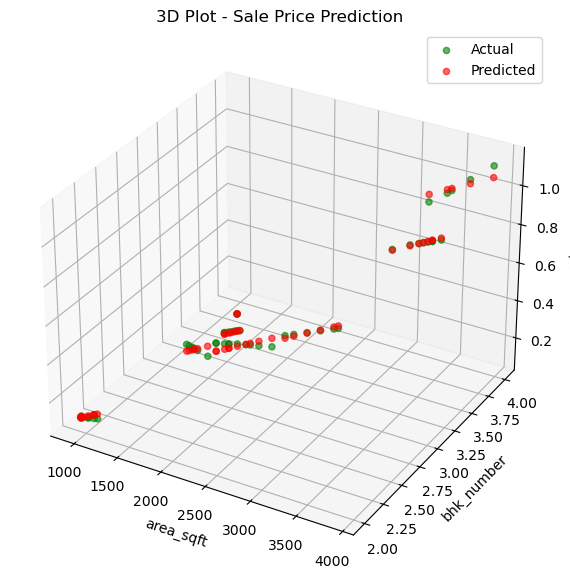

✅ Model saved successfully as model.pkl

--- Rent Prediction ---
MSE: 1222777.64, RMSE: 1105.79, R²: 0.9961


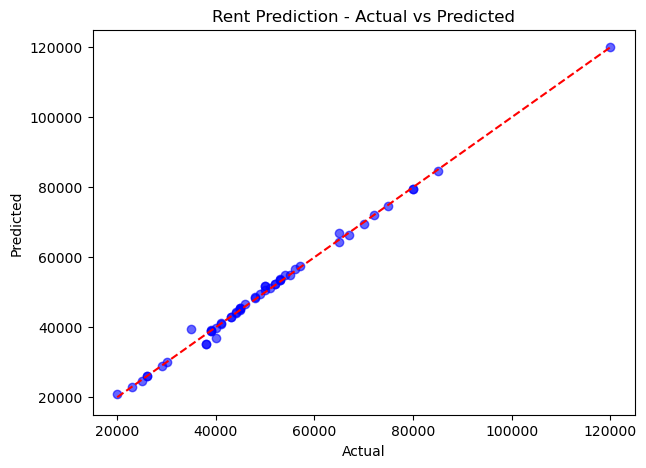

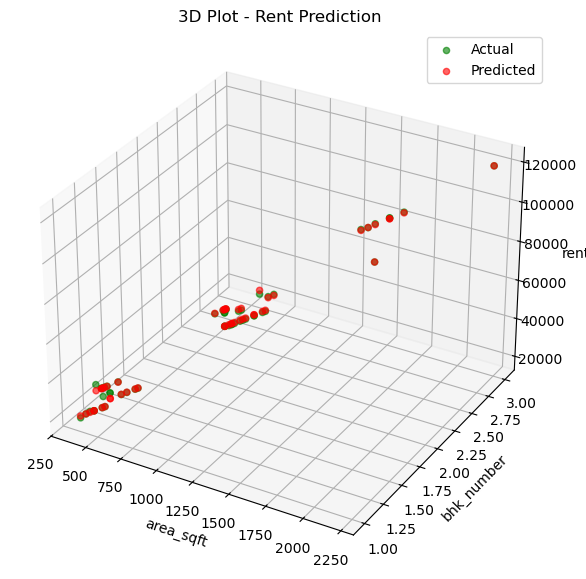

In [39]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D

# Load dataset
df = pd.read_excel("real_estate_analysis.xlsx")

print("Columns in dataset:", df.columns.tolist())
print(df.head())

# ---- SMART DETECTION ----
def detect_column(possible_names, df_columns, exclude_keywords=None):
    exclude_keywords = exclude_keywords or []
    for name in df_columns:
        lower_name = name.lower()
        if any(possible.lower() in lower_name for possible in possible_names):
            if not any(ex.lower() in lower_name for ex in exclude_keywords):
                return name
    return None

# Detect columns
transaction_col = detect_column(['transaction'], df.columns, exclude_keywords=['property'])
area_col = detect_column(['sqft', 'square', 'area'], df.columns)
price_col = detect_column(['price', 'cost', 'amount'], df.columns)
rent_col = detect_column(['rent', 'monthly_rent', 'lease'], df.columns)
location_col = detect_column(['location', 'place', 'city', 'area locality'], df.columns)
bhk_col = detect_column(['bhk', 'bed', 'rooms'], df.columns)

print(f"\nDetected columns:")
print(f"Transaction type column: {transaction_col}")
print(f"Area column: {area_col}")
print(f"BHK column: {bhk_col}")
print(f"Location column: {location_col}")
print(f"Price column: {price_col}")
print(f"Rent column: {rent_col}")

# ---- Clean up ----
if transaction_col:
    df[transaction_col] = df[transaction_col].astype(str).str.lower().fillna("")

# ---- Helper Function ----
def train_and_plot(df_sub, target_col, title_label):
    if df_sub.empty:
        print(f"\n⚠️ No records found for {title_label}.")
        return

    # Select features
    X = df_sub[[area_col, bhk_col, location_col]]
    y = df_sub[target_col]

    # Drop rows with missing values
    data = pd.concat([X, y], axis=1).dropna()
    X = data[[area_col, bhk_col, location_col]]
    y = data[target_col]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Preprocess: One-hot encode location
    preprocessor = ColumnTransformer(
        transformers=[('loc', OneHotEncoder(handle_unknown='ignore'), [location_col])],
        remainder='passthrough'
    )

    # Create model pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', LinearRegression())])

    # Train
    model.fit(X_train, y_train)
    import joblib
    if title_label == "Rent Prediction":
        joblib.dump(model, "model2.pkl")
        print("✅ Model saved successfully as model2.pkl")

    y_pred = model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\n--- {title_label} ---")
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

    # 2D Plot - Actual vs Predicted
    plt.figure(figsize=(7,5))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(f"{title_label} - Actual vs Predicted")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

    # 3D Plot - Area vs BHK vs Target
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X_test[area_col], X_test[bhk_col], y_test, color='green', label='Actual', alpha=0.6)
    ax.scatter(X_test[area_col], X_test[bhk_col], y_pred, color='red', label='Predicted', alpha=0.6)

    ax.set_title(f"3D Plot - {title_label}")
    ax.set_xlabel(area_col)
    ax.set_ylabel(bhk_col)
    ax.set_zlabel(target_col)
    ax.legend()
    plt.show()

# ---- Train & Test for Sale ----
if transaction_col and price_col:
    sale_df = df[df[transaction_col].str.contains('sale', na=False)]
    train_and_plot(sale_df, price_col, "Sale Price Prediction")

# ---- Train & Test for Rent ----
if transaction_col and rent_col:
    rent_df = df[df[transaction_col].str.contains('rent', na=False)]
    train_and_plot(rent_df, rent_col, "Rent Prediction")


In [41]:
pip show scikit-learn

Name: scikit-learn
Version: 1.5.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: C:\Users\Sumanth\AncondaApp\Lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: imbalanced-learn
Note: you may need to restart the kernel to use updated packages.
